(torch.Size([1, 16000]), torch.Size([1, 64, 81]))

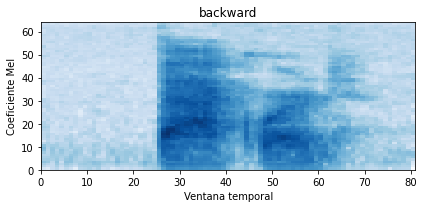

In [1]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import Audio
import torchaudio.transforms as transforms

dataset = torchaudio.datasets.SPEECHCOMMANDS('.', download=True)
train, test = torch.utils.data.random_split(dataset, [80_000, len(dataset)-80_000], 
                                            torch.Generator().manual_seed(1234))

waveform, sample_rate, label, _, _ = dataset[2]
# la frecuencia de muestreo es 16kHz, los audios son de 1 segundo
display(Audio(data=waveform.numpy(), rate=sample_rate))

mel_transform = transforms.MelSpectrogram(sample_rate, n_mels=64)
mel_specgram = mel_transform(waveform)

fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.pcolormesh(mel_specgram[0].log(), cmap=plt.cm.Blues);
ax.set_xlabel('Ventana temporal')
ax.set_ylabel('Coeficiente Mel')
ax.set_title(label)

waveform.shape, mel_specgram.shape

In [2]:
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm

le = LabelEncoder().fit(['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five',
       'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn',
       'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right',
       'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up',
       'visual', 'wow', 'yes', 'zero'])

class simple_rnn(nn.Module):
    
    def __init__(self):
        super(type(self), self).__init__()
        self.lstm = nn.LSTM(input_size=64, 
                            hidden_size=64, 
                            num_layers=2, 
                            bidirectional=False,
                            batch_first=True, 
                            dropout=0.5)
        # in_features debe ser igual a hidden_size
        self.classifier = nn.Linear(in_features=64, 
                                    out_features=len(le.classes_))
        
    def forward(self, x):
        # x.shape = [batch_size, sequence_length, input_size]
        out, _ = self.lstm(x)
        # out.shape = [batch_size, sequence_length, hidden_size]
        # Clasificación en base al último elemento de la secuencia
        return self.classifier(out[:, -1, :])
    
def pad_collate(batch):
    waveforms, sample_rates, labels, _, _ = zip(*batch)
    # Padding con ceros en la dimensión del tiempo (sequence)
    waveforms = [waveform.T for waveform in waveforms]
    waveforms_pad = pad_sequence(waveforms, batch_first=True, padding_value=0)
    # Tranformación a entero de la etiqueta string
    labels_int = torch.from_numpy(le.transform(labels).astype('int'))
    return waveforms_pad.transpose(1, 2), labels_int

train_loader = torch.utils.data.DataLoader(train, batch_size=256, 
                                           shuffle=True, collate_fn=pad_collate)
model = simple_rnn()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in tqdm(range(3)):
    loss_epoch = 0.0
    for waveforms, labels in train_loader:
        # Transformar a logmel
        log_mel = (1e-10+mel_transform(waveforms)).log()
        # Dejar de tamaño [batch_size, ventanas, coeficientes_mel]
        log_mel = log_mel.squeeze(1).transpose(1, 2) 
        # Entrenar:
        optimizer.zero_grad()
        preds = model(log_mel)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()
        
    print(f"{epoch} {loss_epoch}")    
    

  0%|          | 0/3 [00:00<?, ?it/s]

0 803.315563082695
1 469.2497433423996
2 343.46481972932816


In [3]:
import numpy as np

test_loader = torch.utils.data.DataLoader(test, batch_size=256, 
                                          shuffle=False, collate_fn=pad_collate)
preds_, labels_ = [], []
with torch.no_grad():
    for waveforms, labels in tqdm(test_loader):
        log_mel = (1e-10+mel_transform(waveforms)).log()
        log_mel = log_mel.squeeze(1).transpose(1, 2) 
        preds_.append(model(log_mel).argmax(dim=1).detach().numpy())
        labels_.append(labels.detach().numpy())
preds_ = np.concatenate(preds_)
labels_ = np.concatenate(labels_)

  0%|          | 0/101 [00:00<?, ?it/s]

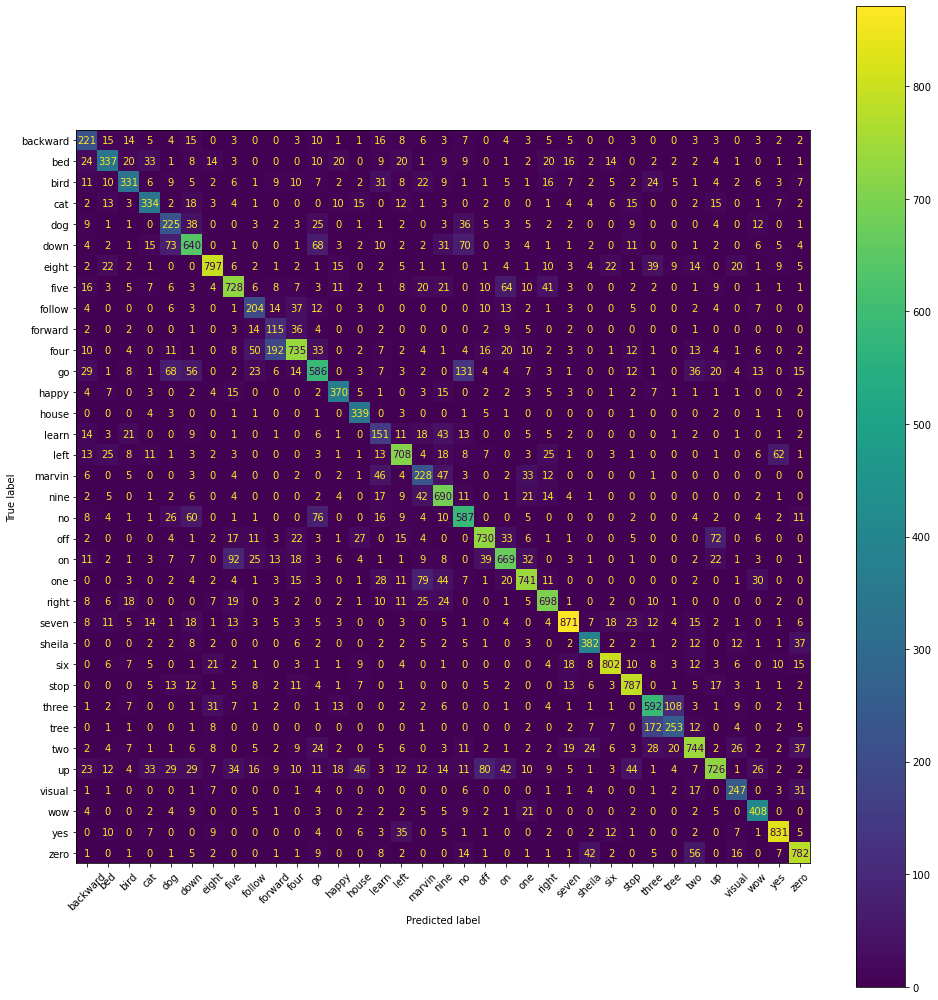

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(14, 14), tight_layout=True)
ConfusionMatrixDisplay.from_predictions(preds_, labels_, ax=ax, 
                                        display_labels=le.classes_, xticks_rotation=45.);